>📘 Learning Objectives
>
> 1. Load ERDDAP data with xarray
> 2. Use some `xarray` functions on data cubes

## Summary

We can open ERDDAP gridded datasets with `xarray`. Make sure that the url points to the dataset without any subsetting of specification. Under the hood, ERDDAP uses OPeNDAP and `xarray` will load the metadata (lazily). After loading, you can subset the data as needed.

We will use the [Multi-scale Ultra-high Resolution (MUR) SST Analysis fv04.1, Global, 0.01°, 2002-present, Daily](https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41.html) data from NASA JPL. This is a high-resolution dataset of over 150 terabytes.

#### For those not working in the JupyterHub

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmfs-opensci/NOAAHackDays/blob/main/topics-2025/2025-02-28-ERDDAP-Py/erddap_xarray.ipynb) and then create a code cell and run `pip install xarray`.

## Load the data set (lazily)

In [10]:
import xarray as xr
url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41"
ds = xr.open_dataset(url)
print(f"Size in TB: {ds.nbytes / 1e12:.2f} TB")
ds.sizes

Size in TB: 150.77 TB


Frozen({'time': 8310, 'latitude': 17999, 'longitude': 36000})

In [11]:
ds

<xarray.Dataset> Size: 151TB
Dimensions:           (time: 8310, latitude: 17999, longitude: 36000)
Coordinates:
  * time              (time) datetime64[ns] 66kB 2002-06-01T09:00:00 ... 2025...
  * latitude          (latitude) float32 72kB -89.99 -89.98 ... 89.98 89.99
  * longitude         (longitude) float32 144kB -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, latitude, longitude) float64 43TB ...
    analysis_error    (time, latitude, longitude) float64 43TB ...
    mask              (time, latitude, longitude) float32 22TB ...
    sea_ice_fraction  (time, latitude, longitude) float64 43TB ...
Attributes: (12/51)
    _NCProperties:              version=2,netcdf=4.7.4,hdf5=1.8.12
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    This is a merged, multi-sensor L4 Foundation ...
    testOutOfDate:              now-3days
    time_coverage_end:          2025-03-04T09:00:00Z
    time_coverage_start:        2002-06-01T09:00:00Z
    title:                      Multi-scale Ultra-high Resolution (MUR) SST A...
    Westernmost_Easting:        -179.99

## Subset this data set

First we will select the SST variable, subset to a 2 degree box and 1 year of data. This will create a much smaller data set or 120 Mb.

In [12]:
dc = ds['analysed_sst'].sel(
                        latitude=slice(33.5, 35.5), 
                        longitude=slice(-75.5, -73.5), 
                        time=slice('2003-01-01', '2003-12-31'))
print(f"Size in GB: {dc.nbytes / 1e9:.2f} GB")
dc.sizes

Size in GB: 0.12 GB


Frozen({'time': 365, 'latitude': 201, 'longitude': 201})

In [13]:
%%time
# Load the data into memory so the next steps are fast
dc.load();

CPU times: user 1.15 s, sys: 275 ms, total: 1.43 s
Wall time: 1min 33s


## Plot one day

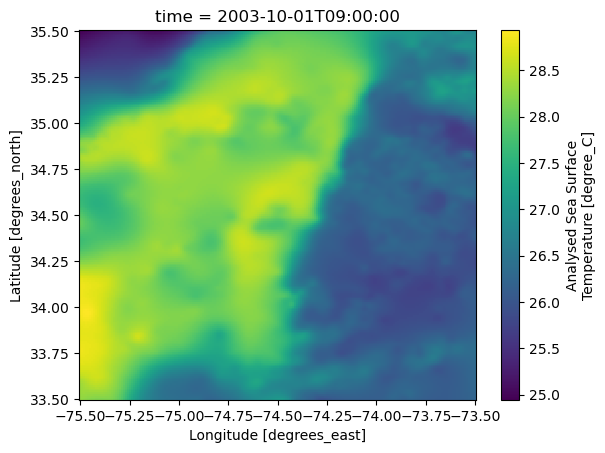

In [14]:
dc.sel(time="2003-10-01").plot();

## Compute the mean SST over the whole data set

Computing the mean for an data array returns a data array and here `.item()` is used to just return the value.

In [15]:
dc.mean().item()

24.8006164888092

### We can plot the spatial mean raster

We do this by taking the mean over the time dimension.

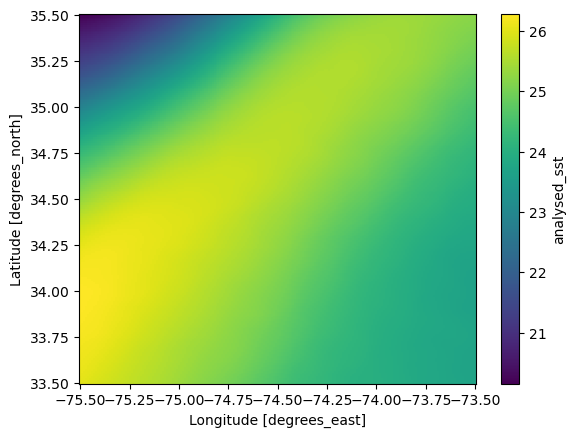

In [16]:
dc.mean(dim=['time']).plot();

### We can plot the daily means

We do this by taking the mean over the space dimensions.

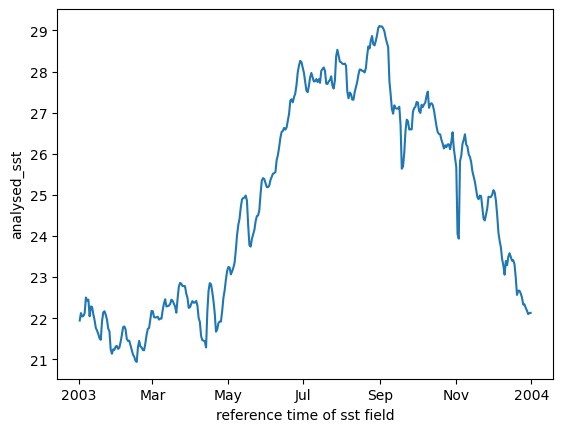

In [17]:
dc.mean(dim=['latitude', 'longitude']).plot();

## Resample to create monthly means

The `resample` function takes a long time if you don't have the data loaded in memory already. So you will want to run something like `dc.load()` (or `dc.mean()` or `dc.compute()`) before running the resample code.

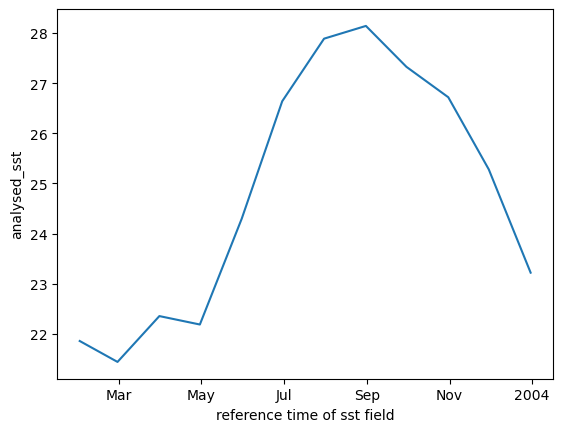

In [18]:
dc_monthly = dc.resample(time='ME').mean()
dc_monthly.mean(dim=['latitude', 'longitude']).plot();

## Chunking to do larger than memory computations

If we load in all the days for our 2 degree square, it is a bit larger than the memory on the small virtual machines (> 2 Gb) of the large data set is 18 Gb. If we try to take the mean of one day it would use up all the memory if we have less than that. We can use `dask` and chunking to do the calculation in smaller chunks so we don't run out of memory.

In [20]:
dc_all = ds['analysed_sst'].sel(
                        latitude=slice(33.5, 35.5), 
                        longitude=slice(-75.5, -73.5),
                        time=slice('2003-01-01', '2006-12-31'))

In [21]:
print(f"Size in GB: {dc_all.nbytes / 1e9:.2f} GB")
dc_all.sizes

Size in GB: 0.47 GB


Frozen({'time': 1461, 'latitude': 201, 'longitude': 201})

Use dask to chunk the data into 500 day chunks. Now when we process the data, it will load only one chunk at a time. We can (slowly) work through all the chunks without maxing out the data.

In [23]:
import dask
dc_chunk = dc_all.chunk({'time': 500, 'latitude': -1, 'longitude': -1})
dc_chunk

<xarray.DataArray 'analysed_sst' (time: 1461, latitude: 201, longitude: 201)> Size: 472MB
dask.array<xarray-<this-array>, shape=(1461, 201, 201), dtype=float64, chunksize=(500, 201, 201), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 12kB 2003-01-01T09:00:00 ... 2006-12-31T...
  * latitude   (latitude) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * longitude  (longitude) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Interim near-real-time (nrt) version using Multi-Resolu...
    ioos_category:    Temperature
    long_name:        Analysed Sea Surface Temperature
    source:           MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTB_G-NAVO,...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        57.767
    valid_min:        -7.767000000000003

In [25]:
# This is takes about 6 minutes
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_all_years = dc_chunk.mean(dim=['latitude', 'longitude']).compute()

[########################################] | 100% Completed | 266.24 s


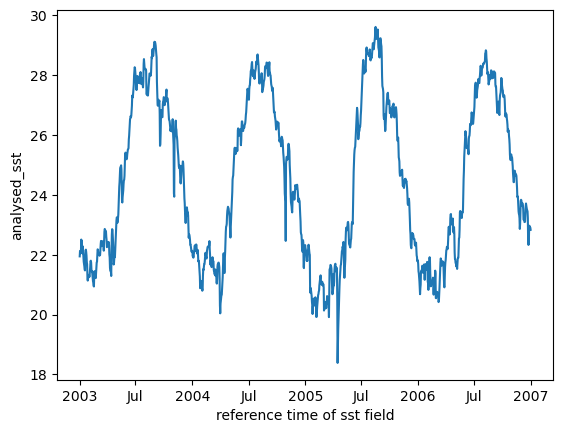

In [28]:
mean_all_years.plot();

We can resample to monthly.

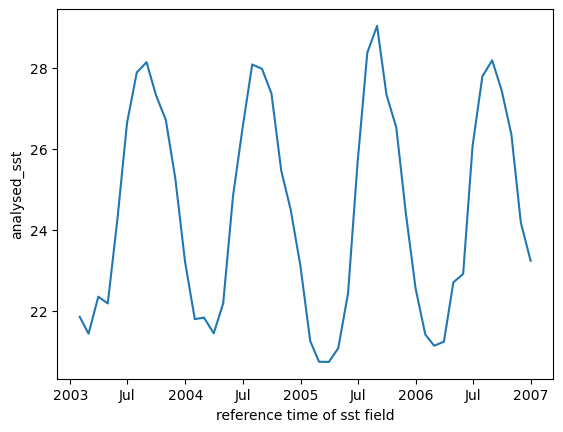

In [30]:
mean_all_years.resample(time='ME').mean().plot();

Note when we loaded all the data in, versus chunking with dask, running this code was fast because the data was already loaded. But with the chunked data, we don't keep all of it in memory so running this would not be fast. Instead, above, the daily data was resampled to monthly.
```
dc_monthly = dc.resample(time='ME').mean()
```

## Compare to Zarr

This dataset is also available on AWS in Zarr format. This is a cloud-optimized format and computations with it are considerably faster.

In [1]:
import xarray
ds2 = xarray.open_zarr("https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1")

In [2]:
dc2 = ds2['analysed_sst'].sel(
                        lat=slice(33.5, 35.5), 
                        lon=slice(-75.5, -73.5),
                        time=slice('2003-01-01', '2006-12-31'))

Processing the chunked data  takes only 1.5 minutes versus 6 minutes with the data on ERDDAP.

In [3]:
import dask
dc2_chunk = dc2.chunk({'time': 500, 'lat': -1, 'lon': -1})
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_all_years = dc2_chunk.mean(dim=['lat', 'lon']).compute()

[########################################] | 100% Completed | 73.60 s


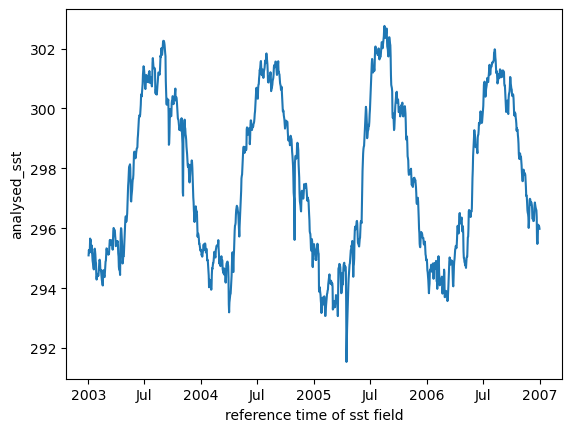

In [4]:
mean_all_years.plot();

## Summary

This tutorial shows you how to create xarray data cubes for gridded data from ERDDAP. The key is to use the url in the right format `<erddap server>/erddap/griddap/<collection id>` with no extra information like `.html` or time or space subsetting, or file type. 

Loading data available in Zarr format (a cloud-optimized format) works similarly and results in faster processing, but cloud-optimized data formats are still relatively uncommon.